# CSCI316 individual assignment 2
- Name: Nguyen Gia Khanh
- UOWID: 7311217

In [69]:
# import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, confusion_matrix

import seaborn as sns
from tensorflow.keras.initializers import HeNormal, GlorotNormal
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

In [70]:
# Read in the data
file_path = 'magic04.data'

# Read the CSV data into a Pandas DataFrame
column_names = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1',
                'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
df = pd.read_csv(file_path, names=column_names)

# Display the DataFrame
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [71]:
# Check missing value
df.isnull().sum()

fLength     0
fWidth      0
fSize       0
fConc       0
fConc1      0
fAsym       0
fM3Long     0
fM3Trans    0
fAlpha      0
fDist       0
class       0
dtype: int64

In [72]:
# Process categorical data
class_label = ['g', 'h']

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the grades
encoder.fit(class_label)
# Encode the 'grade' column in the DataFrame
df['class'] = encoder.transform(df['class'])

In [73]:
# Standardization
label = df['class']
features = df.drop(columns=['class'])
# Standardization
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
# Create a new Pandas DataFrame with scaled features
df = pd.DataFrame(scaled_features, columns=column_names[:-1])  # Exclude the target column

# Add the target column back to the scaled DataFrame
df['class'] = label

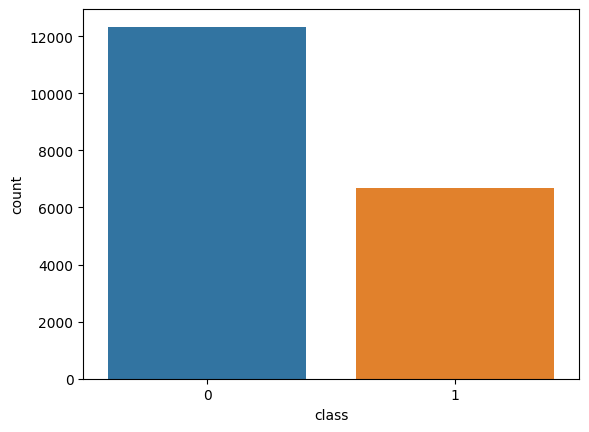

In [74]:
# Distribution of the classes
sns.countplot(data=df, x='class')
plt.show()

# The distribution of the classes is not balanced -> will use oversampling to blance the classes

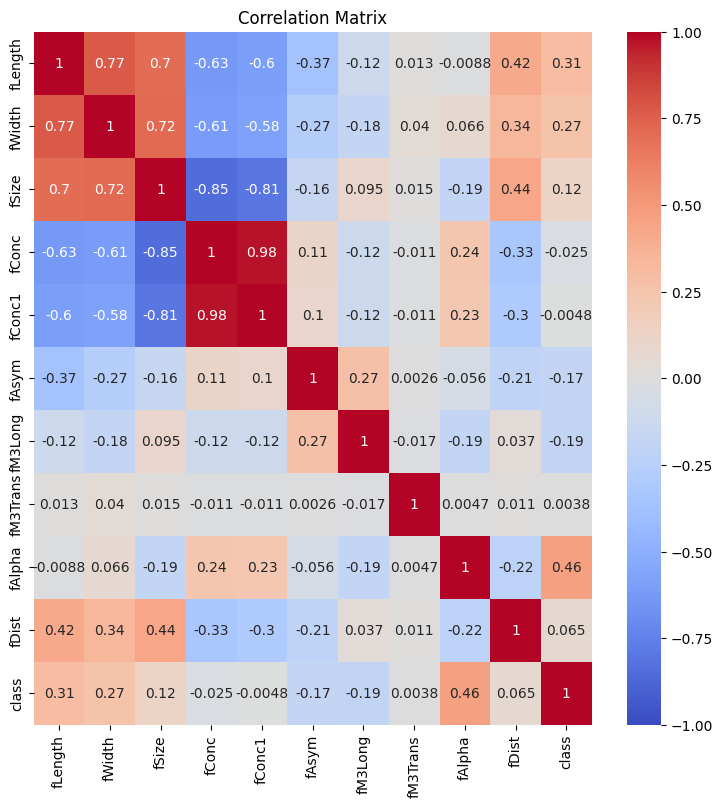

In [75]:
# Visualize - Correlation matrix

# Create a correlation matrix
corr_matrix = df.corr()

# Select the correlation values with 'default_ind'
target_corr = corr_matrix['class']

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(9, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show() 

In [76]:
# Split train/test
x = df.iloc[:,:-1]
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, stratify=y, random_state=42)

In [77]:
# Oversampling with SMOTE
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE on the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [78]:
# Create the model
def create_model(num_hidden_layers, neurons_hidden, regularization):
    if num_hidden_layers != len(neurons_hidden):
        return None
    model = Sequential()
    # Input layer
    model.add(Dense(neurons_hidden[0], activation='relu', kernel_initializer=HeNormal(), input_dim=10))
    # Hidden layers
    for neurons in neurons_hidden[1:]:
        model.add(Dense(neurons, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=tf.keras.regularizers.l1_l2(l1=regularization[0], l2=regularization[1])))
    # Output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer=GlorotNormal()))  # Adjust activation and units
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
# Wrap the Keras model using KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

C:\Users\HP\AppData\Local\Temp\ipykernel_18624\3455780026.py:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


In [79]:
# Setup the hyperparameter grid
param_grid = {
    'num_hidden_layers': [2, 3],
    'neurons_hidden': [
        [16, 8],
        [32, 16],
        [32, 16, 8],
        [29, 14],
    ],
    'regularization': [
        [0.01, 0.001],
        [0.01, 0.01],
        [0.001, 0.01],
        [0.001, 0.001],
    ],
}

# Create GridSearchCV instance
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Perform the grid search
grid_result = grid.fit(X_train_resampled, y_train_resampled)

d:\anaconda\envs\tfgpu\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
80 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda\envs\tfgpu\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\anaconda\envs\tfgpu\lib\site-packages\keras\wrappers\scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
  File "d:\anaconda\envs\tfgpu\lib\site-packages\keras\wrappers\scikit_learn.py", line 167, in fit
    losses.is_categorical_crossentropy(self.model.loss)
AttributeError: 'Non

In [80]:
# Return the best parameters for the model
best_model = grid_result.best_estimator_
best_params = grid_result.best_params_
print("Best parameters:", best_params)

Best parameters: {'neurons_hidden': [32, 16, 8], 'num_hidden_layers': 3, 'regularization': [0.001, 0.001]}


In [81]:
# Plotting the loss and accuracy curves for training and validation
history = best_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split = 0.2)

In [82]:
test_history = best_model.fit(X_test, y_test, epochs=100, batch_size=32, verbose=0, validation_split = 0.2)

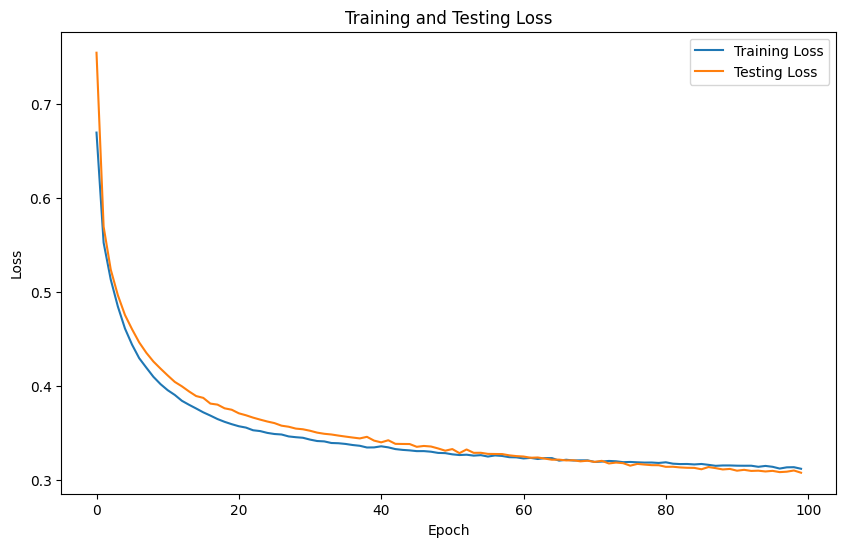

In [83]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(test_history.history['loss'], label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The loss graph above suggests that the model is not overfitting!

In [85]:
# Calculate accuracy
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", acc)
print("AUC-ROC:", auc_roc)
print("F1-Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

197/197 [==============================] - 0s 872us/step
Accuracy: 0.8827465349689342
AUC-ROC: 0.8587684483923723
F1-Score: 0.8235011990407674
Precision: 0.8746816097809476
Recall: 0.777979157227005


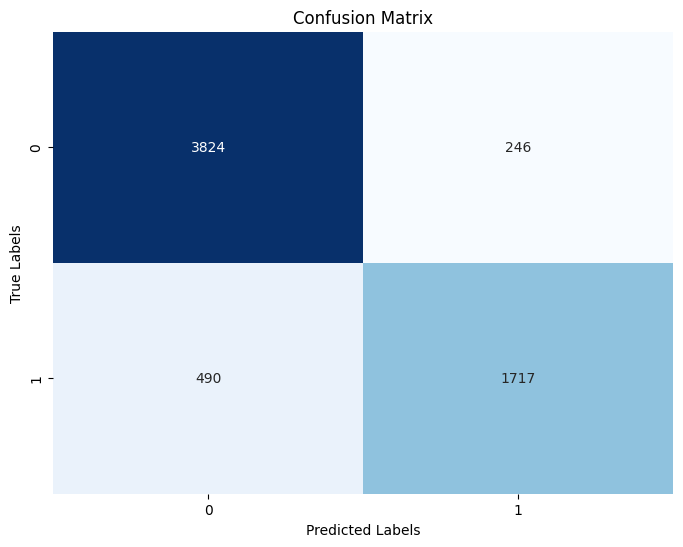

In [86]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Performance evaluation
- Accuracy: The accuracy of ANN model is 88.2% which can be consider good for this problem

- AUC-ROC: The score is 0.859 indicates a reasonably good ability of the model to separate the positive and negative instances.

- F1-Score: The F1-score is about 0.824 indicates a good balance between precision and recall

- Precision: Precision is 0.874, this suggests that the model have a good balance to avoid false positives

- Recall: Recall is 0.778, which means the model is effectively identifying a significant portion of the actual positive instances in the dataset. However, there are also instances that are being missed (false negatives).

Overall, the ANN model seems to be performing fairly well. It has a high accuracy, suggesting that it's making a good number of correct predictions. The AUC-ROC value also indicates a decent ability to differentiate between classes. The F1-score indicates a balance between precision and recall, and both precision and recall values are reasonably high, which is desirable.